# This notebook shows how to fit a resonator in the shunt-coupled (or "hanger") configuration.

In [1]:
from __future__ import division, absolute_import, print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from resonator import background, shunt, see

Create data using the model plus gaussian noise. The model is the product of the shunt resonator model and a background model, which in this case has a tilt in magnitude and a typical value of the cable delay.

In [2]:
# Background parameters
background_model = background.LinearMagnitudeConstantDelay()
magnitude_slope = -1e-8
magnitude_offset = 0.1
phase = -np.pi / 2
delay = 80e-9  # frequency is in Hz, so this is in s

# Foreground parameters
foreground_model = shunt.Shunt()
f_r = 1e9  # resonance frequency
df = 2e6  # frequency width
f = np.linspace(f_r - df / 2, f_r + df / 2, 501)
internal_loss = 5e-5  # Q_i = 20 000
coupling_loss = 5e-5  # Q_c = 20 000
asymmetry = 0.2  # causes rotation and expansion of the resonance circle due to impedance mismatch or parasitic coupling

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=f, frequency_reference=f.min(), phase=phase, delay=delay,
                           magnitude_slope=magnitude_slope, magnitude_offset=magnitude_offset)
fg = foreground_model.func(frequency=f, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss,
                           asymmetry=asymmetry)

# The ideal data is the product of the background and foreground.
s21 = bg * fg

# The measured data will include noise
noise = 0.01 * magnitude_offset
s21n = s21 + noise * (np.random.randn(s21.size) + 1j * np.random.randn(s21.size))

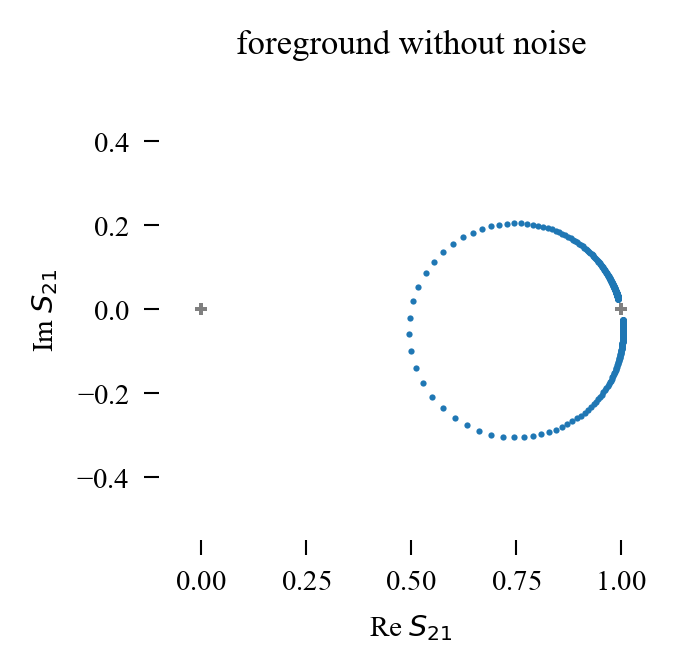

In [3]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(fg.real, fg.imag, '.')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.55, 0.55);
ax.plot([0, 1], [0, 0], marker='P', linestyle='none', color='gray')
ax.set_title('foreground without noise');

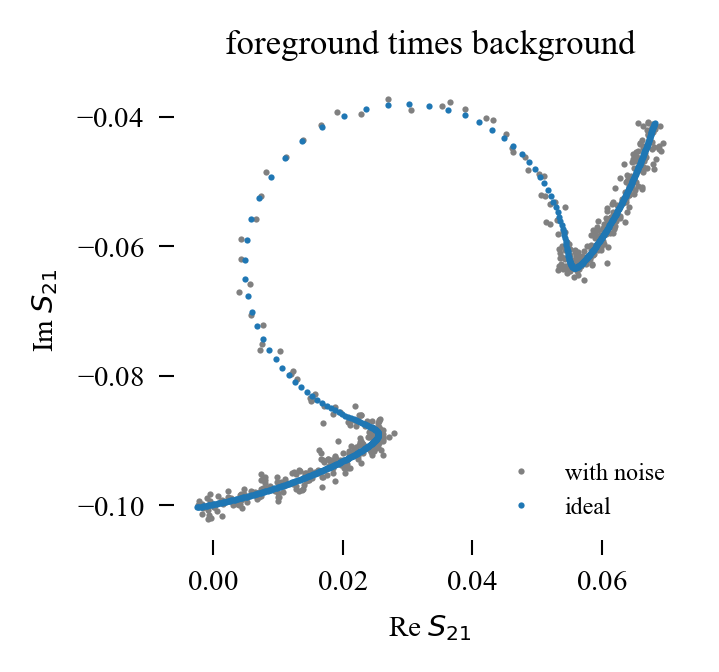

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(s21n.real, s21n.imag, '.', color='gray', label='with noise')
ax.plot(s21.real, s21.imag, '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

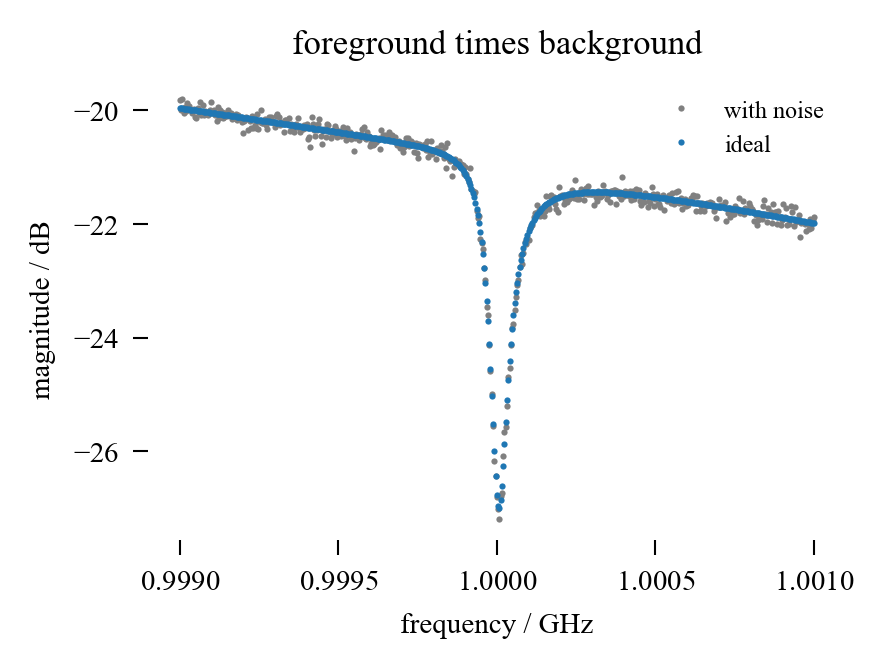

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('magnitude / dB')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21n)), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21)), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

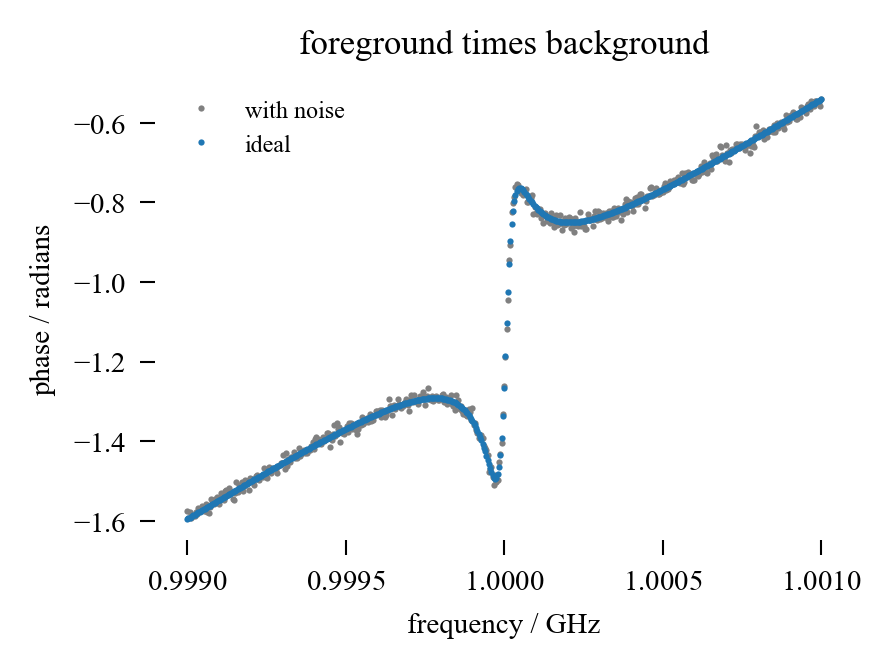

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('phase / radians')
ax.plot(1e-9 * f, np.angle(s21n), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, np.angle(s21), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

## Fit the model to the data using a ShuntFitter.

Note that the default background model (`background.ComplexConstant`) will not work here because the background has too much structure.

Here, we know the standard error of each data point because we added the noise. If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [7]:
resonator = shunt.ShuntFitter(frequency=f, data=s21n, errors=(1 + 1j) * noise * np.ones(f.size),
                              background_model=background.LinearMagnitudeConstantDelay())
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(linear_magnitude_constant_delay) * Model(shunt))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 1002
    # variables        = 8
    chi-square         = 6718.50829
    reduced chi-square = 6.75906267
    Akaike info crit   = 1922.67388
    Bayesian info crit = 1961.95191
[[Variables]]
    frequency_reference:  9.99e+08 (fixed)
    delay:                8.9629e-08 +/- 0.00000000 (0.00%) (init = 9.104749e-08)
    phase:               -1.64795753 +/- 0.00000000 (0.00%) (init = -1.647958)
    magnitude_slope:     -1.0160e-08 +/- 0.00000000 (0.00%) (init = -1.123312e-08)
    magnitude_offset:     0.09960155 +/- 0.00000000 (0.00%) (init = 0.09827797)
    resonance_frequency:  1.0000e+09 +/- 0.00000000 (0.00%) (init = 1.000008e+09)
    internal_loss:        4.2184e-05 +/- 0.00000000 (0.00%) (init = 3.416468e-05)
    coupling_loss:        4.1990e-05 +/- 0.00000000 (0.00%) (init = 3.383478e-05)
    asymmetry:        

## How well do the fit values match the actual values, given the fit standard errors?

In [8]:
print("Normalized deviations: |fit_value - true_value| / fit_standard_error")
print("f_r: {:.2f}".format(abs(resonator.f_r - f_r) / resonator.f_r_error))
print("Q_c: {:.2f}".format(abs(resonator.Q_c - 1 / coupling_loss) / resonator.Q_c_error))
print("Q_i: {:.2f}".format(abs(resonator.Q_i - 1 / internal_loss) / resonator.Q_i_error))
print("asymmetry: {:.2f}".format(abs(resonator.asymmetry - asymmetry) / resonator.asymmetry_error))
print("magnitude_offset: {:.2f}".format(abs(resonator.magnitude_offset - magnitude_offset) / resonator.magnitude_offset_error))
print("magnitude_slope: {:.2f}".format(abs(resonator.magnitude_slope - magnitude_slope) / resonator.magnitude_slope_error))
print("delay: {:.2f}".format(abs(resonator.delay - delay) / resonator.delay_error))
print("phase: {:.2f}".format(abs(resonator.phase - phase) / resonator.phase_error))

Normalized deviations: |fit_value - true_value| / fit_standard_error
f_r: inf
Q_c: inf
Q_i: inf
asymmetry: inf
magnitude_offset: inf
magnitude_slope: inf
delay: inf
phase: inf


C:\Users\dflaniga\AppData\Local\Continuum\miniconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\dflaniga\AppData\Local\Continuum\miniconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dflaniga\AppData\Local\Continuum\miniconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\dflaniga\AppData\Local\Continuum\miniconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
C:\Users\dflaniga\AppData\Local\Continuum\miniconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\dflanig

## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance.

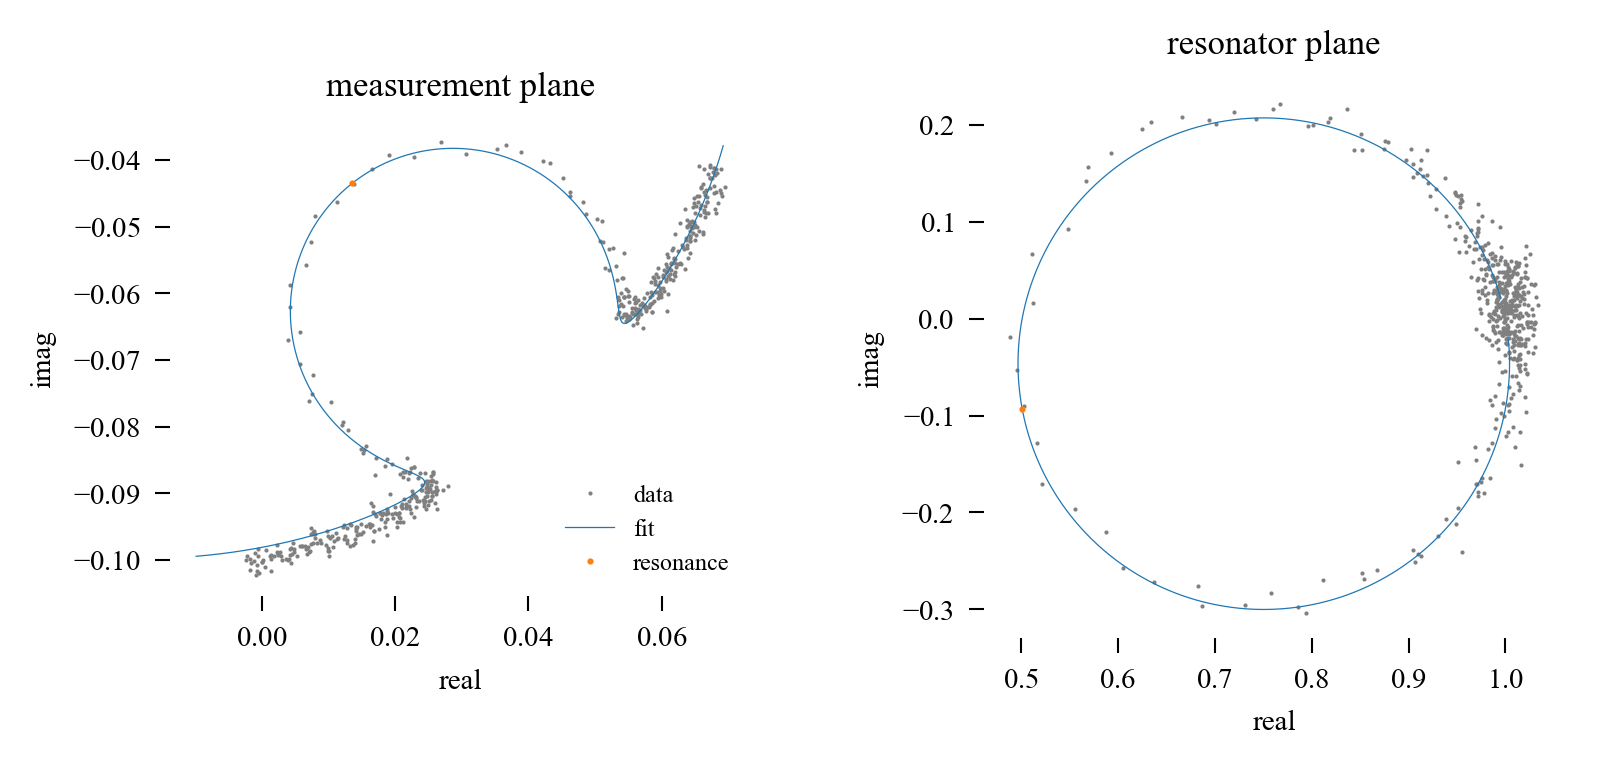

In [9]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

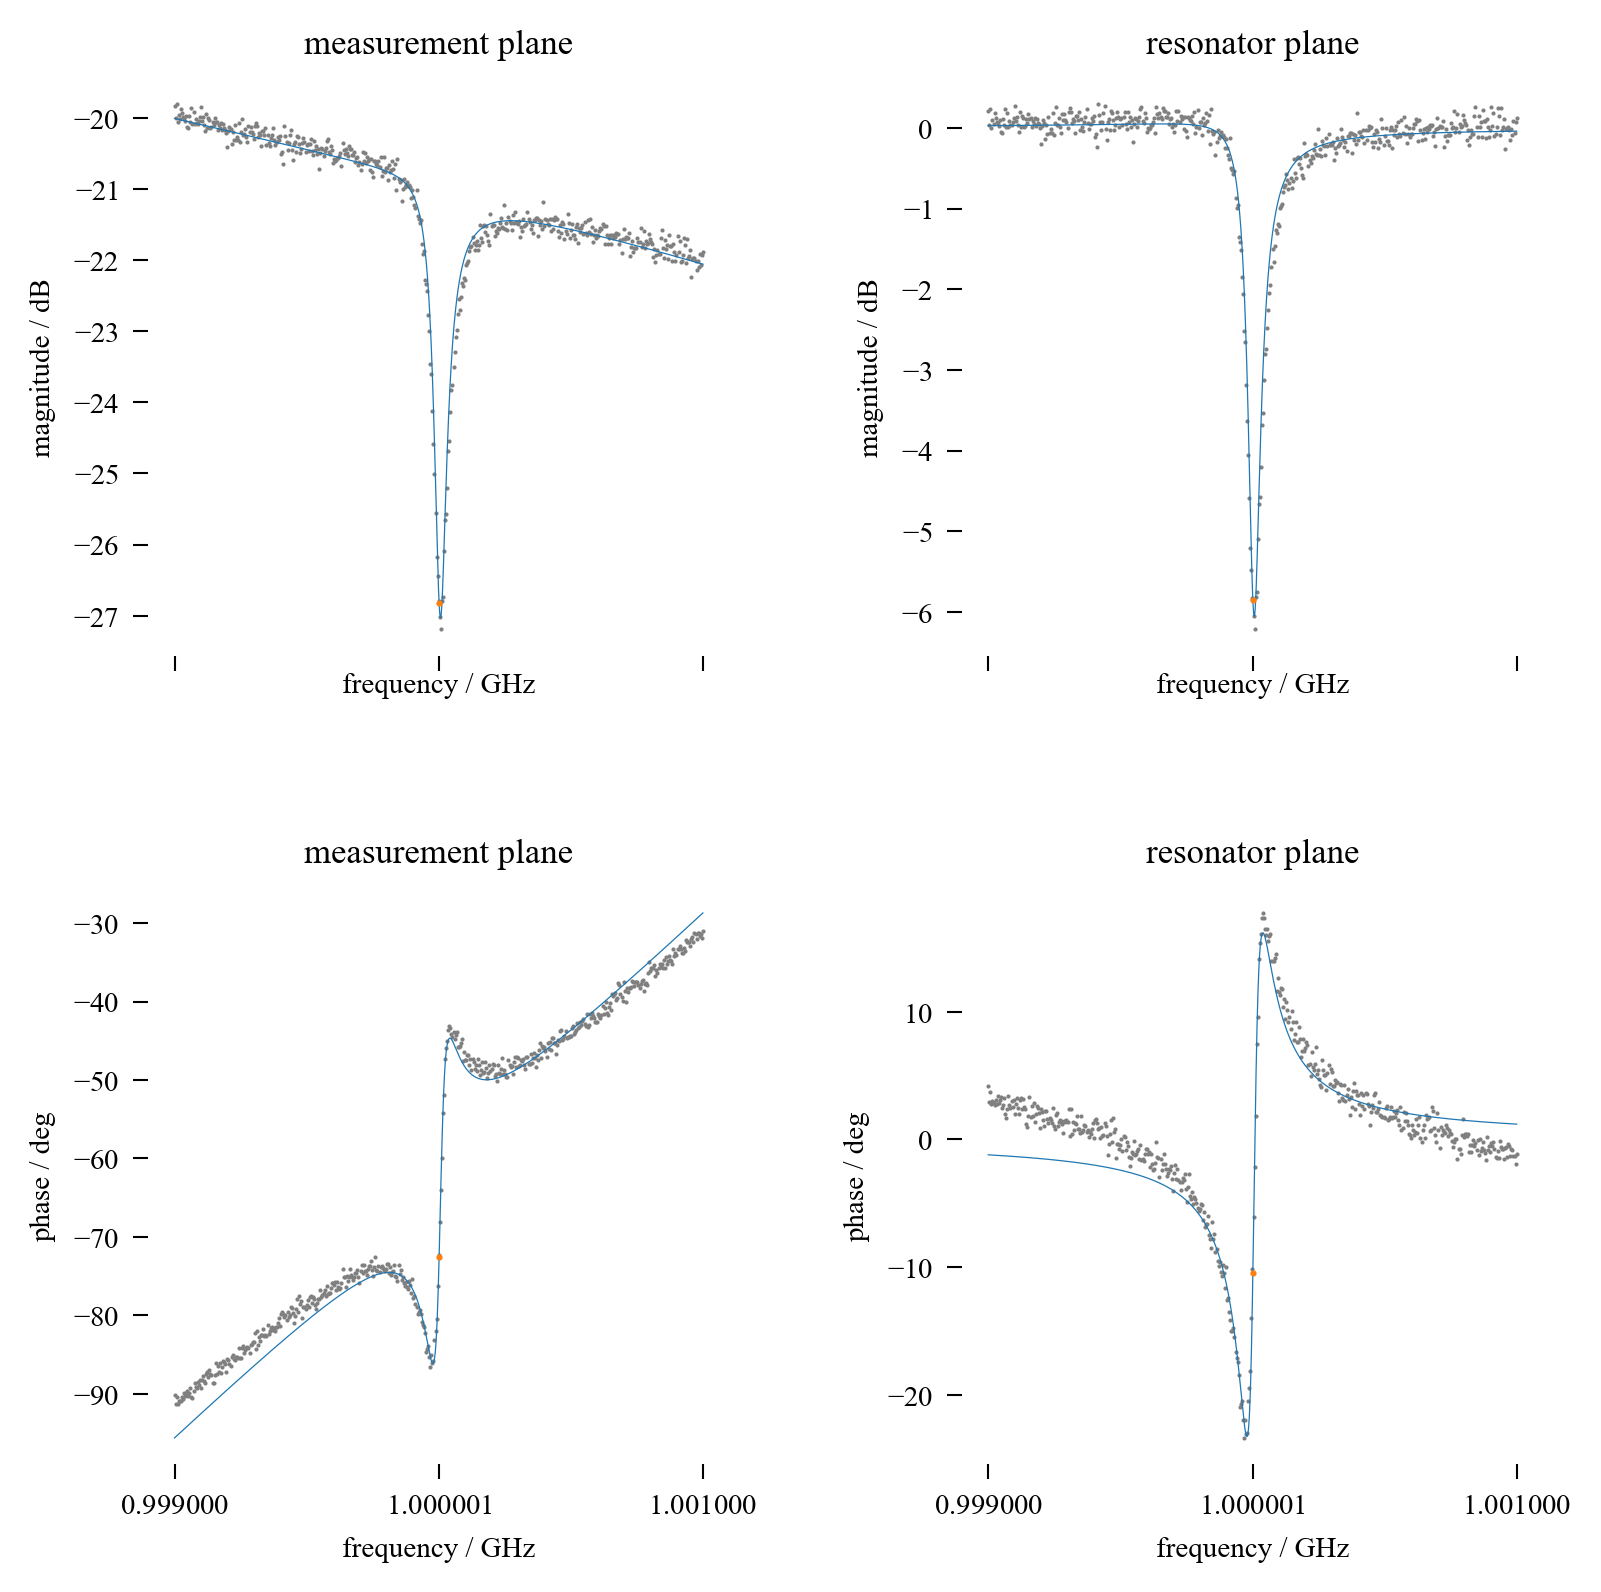

In [10]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);